In [1]:
import json

import scipy as sp
import pandas as pd
import numpy as np

from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold

from collections import Counter
import os
import sys
import pickle
import gc
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备 
os.environ["CUDA_VISIBLE_DEVICES"] = "3" #设置当前使用的GPU设备仅为0号设备  设备名称为'/gpu:0'import sys
import lightgbm as lgb
np.random.seed(369)

import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


## Image Features

In [2]:
import cv2
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121



Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [3]:
train = pd.read_csv("./data/task3/train.csv")
test = pd.read_csv("./data/task3/task3_new_stage2.csv")

In [4]:
len(test),len(train)

(3999, 38471)

In [5]:
train.head()

,id,text,piclist,userGender,userFollowCount,userFansCount,userWeiboCount,userLocation,userDescription,category,label
0,84cdcfed1aeb7047ad168be7bb9b559e,回复新浪网友对博文【国家文物局限制鉴宝节目现场估价转】的评论：;;查看原文：,NaN,男,1728.0,748.0,30884.0,北京朝阳区,我们虚度的今天恰是。。昨天去世人渴望的明天。,文体娱乐,0
1,93ebc056c547618b5b00ab35270c9fad,//分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....,63ad082a189566eed7c4bb3e4bc55012.jpg,男,423.0,112.0,792.0,云南楚雄,用心生活,社会生活,0
2,eefcba3b5856fe8f55213e036ee463ca,西宁城管围殴民警扬言要把警察打死|西宁城管围...,4986dc2a5f09a87c7af5dfc57d7775cd.jpg,NaN,NaN,NaN,NaN,NaN,NaN,社会生活,0
3,8e09b1b13477f62139b5cd7a7a7dcb8f,【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...,dcfccfc69e90a0007afd6aafa1385e56.jpg,女,1668.0,7470000.0,57256.0,北京东城区,中国青年报•中青在线微博,社会生活,0
4,9ffea4d9573c6e723e8f178a789888dc,支持郑强！！！//【贵州大学校长回应空姐言论:常给她们写感谢信】,NaN,男,267.0,61.0,1098.0,江苏盐城,能烧得全烧了，只剩下石头。,社会生活,0


In [10]:
fake_pic_dir = os.listdir("./data/task3/train/data/rumor/rumor_pic/")
true_pic_dir = os.listdir("./data/task3/train/data/truth/")
all_images_dir = os.listdir("./data/task3/train/all_img/")

In [11]:
len(fake_pic_dir+true_pic_dir),len(all_images_dir)

(14445, 12228)

In [12]:
train.piclist

0                                                      NaN
1                     63ad082a189566eed7c4bb3e4bc55012.jpg
2                     4986dc2a5f09a87c7af5dfc57d7775cd.jpg
3                     dcfccfc69e90a0007afd6aafa1385e56.jpg
4                                                      NaN
5                                                      NaN
6                     c27128539623efd8b07135aa583921ed.jpg
7                     98f293c7e67688a8384be27cb74ab6e4.jpg
8                     1eac69927d35ba0d813bbbca0441a5ff.jpg
9        ff59503827f3d9f6c0b0723e5d39cb39.jpg\tcd1b58b4...
10                    2b1c16af2f29aa64796fad48389cfa1c.jpg
11                    244139d24309ff08550c5562f466d6bf.jpg
12                    4dcbb6806fbb27d6d9d5d79cd79b0c9b.jpg
13                    0973b409406fb548e038fdf81a638757.jpg
14       847437169d65b4511d4a92065d0e516b.jpg\t7db7d685...
15                                                     NaN
16                    f55a59db08f88f009ddd81eb741d654e.j

In [14]:
train.text

0                   回复新浪网友对博文【国家文物局限制鉴宝节目现场估价转】的评论：;;查看原文：
1        //分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....
2                                西宁城管围殴民警扬言要把警察打死|西宁城管围...
3        【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...
4                         支持郑强！！！//【贵州大学校长回应空姐言论:常给她们写感谢信】
5        分享网易新闻《湖南道县一按摩店员工因琐事矛盾捅死老板夫妻》http://t.cn/RtpJM...
6        #地震快讯#中国地震台网自动测定：08月08日21时19分在四川阿坝州九寨沟县附近（北纬33...
7        #长沙身边事#【石门-常德-长沙动车时刻表出炉9月21日开行】来了，来了，石长铁路动车真的来...
8             战事一触即发？伊朗大规模海上军演向美示威，美将派更多军舰前往!!!!!|战事一触即...
9        #北京那点事儿#【嚣张宾利女司机违规停车保安劝离遭殴眼球可能面临摘除】@F小貝貝：昨天，顺义...
10       贵州一天然气管发生燃烧爆炸据黔西南州消防部门提供的消息，今天上午10:44，在贵州省黔西南州...
11       分享网易新闻:《萧山坎山重大车祸4死5伤，肇事司机被抓获！》http://t.cn/RqUf...
12       【起底长生生物：“魔鬼”是怎样炼成的？】7月15日，长生生物被爆出狂犬病疫苗生产记录造假，随...
13                                       河北燕郊首富之孙驾宾利撞面包车身亡
14       【正能量！一晚俩网友爆料，表扬的竟是同一外卖小哥】月初长沙暴雨，某外卖主管一晚接到俩网友爆料...
15       【港大：新药可除艾滋病！】4月26日，香港大学宣布该校艾滋病研究所研制出一种新型抗体药物（B...
16       【西安：两男子“婚闹”猥亵伴娘警方介入调查】6月8号，一段视频在网上传播。视频中，两名男子对.

In [15]:
train.category

0        文体娱乐
1        社会生活
2        社会生活
3        社会生活
4        社会生活
5        社会生活
6        社会生活
7        社会生活
8          军事
9        社会生活
10       社会生活
11       财经商业
12       医药健康
13       社会生活
14       社会生活
15       医药健康
16       社会生活
17       社会生活
18       社会生活
19       社会生活
20         军事
21       医药健康
22       财经商业
23       社会生活
24       社会生活
25       社会生活
26       医药健康
27       社会生活
28       社会生活
29       社会生活
         ... 
38441    社会生活
38442    社会生活
38443    社会生活
38444    教育考试
38445    社会生活
38446    社会生活
38447    社会生活
38448    医药健康
38449    社会生活
38450    社会生活
38451    社会生活
38452    社会生活
38453    社会生活
38454      科技
38455    社会生活
38456    教育考试
38457    社会生活
38458    财经商业
38459      军事
38460    社会生活
38461    社会生活
38462    社会生活
38463    社会生活
38464    社会生活
38465    社会生活
38466    社会生活
38467    社会生活
38468    医药健康
38469    文体娱乐
38470    社会生活
Name: category, Length: 38471, dtype: object

In [16]:
train.label

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
38441    1
38442    1
38443    1
38444    1
38445    1
38446    1
38447    1
38448    1
38449    1
38450    1
38451    1
38452    1
38453    1
38454    1
38455    1
38456    1
38457    1
38458    1
38459    1
38460    1
38461    1
38462    1
38463    1
38464    1
38465    1
38466    1
38467    1
38468    1
38469    1
38470    1
Name: label, Length: 38471, dtype: int64

In [40]:
len(test.piclist)

3999

In [22]:
len(train.piclist)

38471

In [25]:
train[train.piclist.notna()]

,id,text,piclist,userGender,userFollowCount,userFansCount,userWeiboCount,userLocation,userDescription,category,label
1,93ebc056c547618b5b00ab35270c9fad,//分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....,63ad082a189566eed7c4bb3e4bc55012.jpg,男,423.0,112.0,792.0,云南楚雄,用心生活,社会生活,0
2,eefcba3b5856fe8f55213e036ee463ca,西宁城管围殴民警扬言要把警察打死|西宁城管围...,4986dc2a5f09a87c7af5dfc57d7775cd.jpg,NaN,NaN,NaN,NaN,NaN,NaN,社会生活,0
3,8e09b1b13477f62139b5cd7a7a7dcb8f,【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...,dcfccfc69e90a0007afd6aafa1385e56.jpg,女,1668.0,7470000.0,57256.0,北京东城区,中国青年报•中青在线微博,社会生活,0
6,8aea1df51257433a9c59970774e4caea,#地震快讯#中国地震台网自动测定：08月08日21时19分在四川阿坝州九寨沟县附近（北纬33...,c27128539623efd8b07135aa583921ed.jpg,男,731.0,7530000.0,57357.0,浙江杭州,《都市快报》官方微博,社会生活,0
7,98048512d68b1aff9b6c3b07bf32c04f,#长沙身边事#【石门-常德-长沙动车时刻表出炉9月21日开行】来了，来了，石长铁路动车真的来...,98f293c7e67688a8384be27cb74ab6e4.jpg,男,439.0,460000.0,66419.0,湖南长沙,湖南交通台官方微博,社会生活,0
8,0f83f39e02ea2aa9734ecfdaebaefc19,战事一触即发？伊朗大规模海上军演向美示威，美将派更多军舰前往!!!!!|战事一触即...,1eac69927d35ba0d813bbbca0441a5ff.jpg,女,205.0,30916.0,1339.0,北京东城区,知名时尚博主,军事,0
9,07a132b8d9bd417d5b0f99792c2c9dc4,#北京那点事儿#【嚣张宾利女司机违规停车保安劝离遭殴眼球可能面临摘除】@F小貝貝：昨天，顺义...,ff59503827f3d9f6c0b0723e5d39cb39.jpg\tcd1b58b4...,女,1675.0,220000.0,20740.0,北京海淀区,乐活北京官方微博,社会生活,0
10,b6dabbbab8b15e9b881dba6939ea020b,贵州一天然气管发生燃烧爆炸据黔西南州消防部门提供的消息，今天上午10:44，在贵州省黔西南州...,2b1c16af2f29aa64796fad48389cfa1c.jpg,男,992.0,7094.0,7118.0,福建福州,报社记者,社会生活,0
11,253131e80babc3e584eb1f45ff92ca21,分享网易新闻:《萧山坎山重大车祸4死5伤，肇事司机被抓获！》http://t.cn/RqUf...,244139d24309ff08550c5562f466d6bf.jpg,男,196.0,81.0,138.0,浙江杭州,很多时候，大叔是可爱的呦π_π,财经商业,0
12,83518562e0e260e300a1784284fdbb35,【起底长生生物：“魔鬼”是怎样炼成的？】7月15日，长生生物被爆出狂犬病疫苗生产记录造假，随...,4dcbb6806fbb27d6d9d5d79cd79b0c9b.jpg,男,632.0,880000.0,37614.0,北京,凤凰网科技频道官方微博,医药健康,0


In [29]:
len(train[train.piclist.notna()])

21832

In [30]:
def pic_is_fake(x):
    x = str(x)
    if x in fake_pic_dir:
        return 1
    if x in true_pic_dir:
        return 2
    return 0

def pic_path(x):
    x = str(x)
    if x in all_images_dir:
        return "./data/task3/train/all_img/"+x
    return  np.nan

In [32]:
data = pd.concat([train,test])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [41]:
data['piclist'].apply(lambda x:pic_is_fake(x))

0       0
1       0
2       0
3       0
4       0
5       0
6       2
7       0
8       2
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
3969    0
3970    0
3971    0
3972    0
3973    0
3974    0
3975    0
3976    0
3977    0
3978    0
3979    0
3980    0
3981    0
3982    0
3983    0
3984    0
3985    0
3986    0
3987    0
3988    0
3989    0
3990    0
3991    0
3992    0
3993    0
3994    0
3995    0
3996    0
3997    0
3998    0
Name: piclist, Length: 42470, dtype: int64

In [42]:
data['is_fake_pic'] = data['piclist'].apply(lambda x:pic_is_fake(x))

In [43]:
data

,category,id,label,piclist,text,userDescription,userFansCount,userFollowCount,userGender,userLocation,userWeiboCount,is_fake_pic
0,文体娱乐,84cdcfed1aeb7047ad168be7bb9b559e,0.0,NaN,回复新浪网友对博文【国家文物局限制鉴宝节目现场估价转】的评论：;;查看原文：,我们虚度的今天恰是。。昨天去世人渴望的明天。,748.0,1728.0,男,北京朝阳区,30884.0,0
1,社会生活,93ebc056c547618b5b00ab35270c9fad,0.0,63ad082a189566eed7c4bb3e4bc55012.jpg,//分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....,用心生活,112.0,423.0,男,云南楚雄,792.0,0
2,社会生活,eefcba3b5856fe8f55213e036ee463ca,0.0,4986dc2a5f09a87c7af5dfc57d7775cd.jpg,西宁城管围殴民警扬言要把警察打死|西宁城管围...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,社会生活,8e09b1b13477f62139b5cd7a7a7dcb8f,0.0,dcfccfc69e90a0007afd6aafa1385e56.jpg,【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...,中国青年报•中青在线微博,7470000.0,1668.0,女,北京东城区,57256.0,0
4,社会生活,9ffea4d9573c6e723e8f178a789888dc,0.0,NaN,支持郑强！！！//【贵州大学校长回应空姐言论:常给她们写感谢信】,能烧得全烧了，只剩下石头。,61.0,267.0,男,江苏盐城,1098.0,0
5,社会生活,e7348f3ea7551ebbd4d653f450ee2f28,0.0,NaN,分享网易新闻《湖南道县一按摩店员工因琐事矛盾捅死老板夫妻》http://t.cn/RtpJM...,天天开心，时时快乐，活在当下，幸福美满！,1399.0,2003.0,男,江苏常州,26884.0,0
6,社会生活,8aea1df51257433a9c59970774e4caea,0.0,c27128539623efd8b07135aa583921ed.jpg,#地震快讯#中国地震台网自动测定：08月08日21时19分在四川阿坝州九寨沟县附近（北纬33...,《都市快报》官方微博,7530000.0,731.0,男,浙江杭州,57357.0,2
7,社会生活,98048512d68b1aff9b6c3b07bf32c04f,0.0,98f293c7e67688a8384be27cb74ab6e4.jpg,#长沙身边事#【石门-常德-长沙动车时刻表出炉9月21日开行】来了，来了，石长铁路动车真的来...,湖南交通台官方微博,460000.0,439.0,男,湖南长沙,66419.0,0
8,军事,0f83f39e02ea2aa9734ecfdaebaefc19,0.0,1eac69927d35ba0d813bbbca0441a5ff.jpg,战事一触即发？伊朗大规模海上军演向美示威，美将派更多军舰前往!!!!!|战事一触即...,知名时尚博主,30916.0,205.0,女,北京东城区,1339.0,2
9,社会生活,07a132b8d9bd417d5b0f99792c2c9dc4,0.0,ff59503827f3d9f6c0b0723e5d39cb39.jpg\tcd1b58b4...,#北京那点事儿#【嚣张宾利女司机违规停车保安劝离遭殴眼球可能面临摘除】@F小貝貝：昨天，顺义...,乐活北京官方微博,220000.0,1675.0,女,北京海淀区,20740.0,0


In [44]:
data['piclist_path'] = data['piclist'].apply(lambda x:pic_path(x))

In [45]:
data

,category,id,label,piclist,text,userDescription,userFansCount,userFollowCount,userGender,userLocation,userWeiboCount,is_fake_pic,piclist_path
0,文体娱乐,84cdcfed1aeb7047ad168be7bb9b559e,0.0,NaN,回复新浪网友对博文【国家文物局限制鉴宝节目现场估价转】的评论：;;查看原文：,我们虚度的今天恰是。。昨天去世人渴望的明天。,748.0,1728.0,男,北京朝阳区,30884.0,0,NaN
1,社会生活,93ebc056c547618b5b00ab35270c9fad,0.0,63ad082a189566eed7c4bb3e4bc55012.jpg,//分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....,用心生活,112.0,423.0,男,云南楚雄,792.0,0,NaN
2,社会生活,eefcba3b5856fe8f55213e036ee463ca,0.0,4986dc2a5f09a87c7af5dfc57d7775cd.jpg,西宁城管围殴民警扬言要把警察打死|西宁城管围...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,社会生活,8e09b1b13477f62139b5cd7a7a7dcb8f,0.0,dcfccfc69e90a0007afd6aafa1385e56.jpg,【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...,中国青年报•中青在线微博,7470000.0,1668.0,女,北京东城区,57256.0,0,NaN
4,社会生活,9ffea4d9573c6e723e8f178a789888dc,0.0,NaN,支持郑强！！！//【贵州大学校长回应空姐言论:常给她们写感谢信】,能烧得全烧了，只剩下石头。,61.0,267.0,男,江苏盐城,1098.0,0,NaN
5,社会生活,e7348f3ea7551ebbd4d653f450ee2f28,0.0,NaN,分享网易新闻《湖南道县一按摩店员工因琐事矛盾捅死老板夫妻》http://t.cn/RtpJM...,天天开心，时时快乐，活在当下，幸福美满！,1399.0,2003.0,男,江苏常州,26884.0,0,NaN
6,社会生活,8aea1df51257433a9c59970774e4caea,0.0,c27128539623efd8b07135aa583921ed.jpg,#地震快讯#中国地震台网自动测定：08月08日21时19分在四川阿坝州九寨沟县附近（北纬33...,《都市快报》官方微博,7530000.0,731.0,男,浙江杭州,57357.0,2,./data/task3/train/all_img/c27128539623efd8b07...
7,社会生活,98048512d68b1aff9b6c3b07bf32c04f,0.0,98f293c7e67688a8384be27cb74ab6e4.jpg,#长沙身边事#【石门-常德-长沙动车时刻表出炉9月21日开行】来了，来了，石长铁路动车真的来...,湖南交通台官方微博,460000.0,439.0,男,湖南长沙,66419.0,0,NaN
8,军事,0f83f39e02ea2aa9734ecfdaebaefc19,0.0,1eac69927d35ba0d813bbbca0441a5ff.jpg,战事一触即发？伊朗大规模海上军演向美示威，美将派更多军舰前往!!!!!|战事一触即...,知名时尚博主,30916.0,205.0,女,北京东城区,1339.0,2,./data/task3/train/all_img/1eac69927d35ba0d813...
9,社会生活,07a132b8d9bd417d5b0f99792c2c9dc4,0.0,ff59503827f3d9f6c0b0723e5d39cb39.jpg\tcd1b58b4...,#北京那点事儿#【嚣张宾利女司机违规停车保安劝离遭殴眼球可能面临摘除】@F小貝貝：昨天，顺义...,乐活北京官方微博,220000.0,1675.0,女,北京海淀区,20740.0,0,NaN


In [46]:
len(data[data['piclist_path'].notna()])

6789

In [47]:
data[data['piclist_path'].notna()]

,category,id,label,piclist,text,userDescription,userFansCount,userFollowCount,userGender,userLocation,userWeiboCount,is_fake_pic,piclist_path
6,社会生活,8aea1df51257433a9c59970774e4caea,0.0,c27128539623efd8b07135aa583921ed.jpg,#地震快讯#中国地震台网自动测定：08月08日21时19分在四川阿坝州九寨沟县附近（北纬33...,《都市快报》官方微博,7530000.0,731.0,男,浙江杭州,57357.0,2,./data/task3/train/all_img/c27128539623efd8b07...
8,军事,0f83f39e02ea2aa9734ecfdaebaefc19,0.0,1eac69927d35ba0d813bbbca0441a5ff.jpg,战事一触即发？伊朗大规模海上军演向美示威，美将派更多军舰前往!!!!!|战事一触即...,知名时尚博主,30916.0,205.0,女,北京东城区,1339.0,2,./data/task3/train/all_img/1eac69927d35ba0d813...
21,医药健康,e9946b2bb5c5fd79c3fadb028bf99a30,0.0,65989dbc3e70ce41aa3966882fe218f4.jpg,日本狗！书籍只有英文日本很多中国人看不懂，日本APA连锁酒店客房中，放置大量由该酒店集团CE...,心境似湖,10309.0,109.0,女,辽宁大连,100.0,0,./data/task3/train/all_img/65989dbc3e70ce41aa3...
54,医药健康,2db5624c4734c2c8b2eb0128ccdc174e,0.0,87de1c5b7aee21e96197487e668a4186.jpg,健康新警示-“四高”继高血压、高血糖、高血脂这“三高”之后，高尿酸已成为威胁国民健康的“第四...,生物制药公司职业经理人 优点：实在；缺点：太实在,162.0,247.0,男,北京海淀区,228.0,2,./data/task3/train/all_img/87de1c5b7aee21e9619...
111,社会生活,7a89e928a1d1aa8ad7a3a4fb99c18e07,0.0,e827ab9146d7776e9982a9d5816a8a22.jpg,#地震快讯#中国地震台网正式测定：08月08日21时41分在四川省阿坝州九寨沟县（纬度33....,陕西省咸阳市地震局官方微博,286.0,93.0,男,陕西咸阳,2985.0,2,./data/task3/train/all_img/e827ab9146d7776e998...
185,社会生活,14e826de7f082afed25897a0051d82c9,0.0,b2292e920b7dae67df56de68cb8eb78b.jpg,【广西苍梧发生5.4级地震：震源深度10千米，多地有震感】中国地震台网正式测定：07月31日...,扬州网官方微博,160000.0,1915.0,男,江苏扬州,47288.0,2,./data/task3/train/all_img/b2292e920b7dae67df5...
208,社会生活,c8130bb46f5927f1a7e53c7af5485be5,0.0,f080becbad5a442a524b69dfc14be9a2.jpg,姥姥病重欲请假老师让学生置生死于度外#UC头条#,樱花下落的速度，依旧是秒速五厘米。而不论我们之间通过千条短信，我们之间的距离也不会拉近一厘米……,53.0,443.0,男,江苏苏州,693.0,2,./data/task3/train/all_img/f080becbad5a442a524...
236,财经商业,41cc18d5bfa1ee55ddecc6fe4cebdbb1,0.0,65989dbc3e70ce41aa3966882fe218f4.jpg,三诺生物[股评]参与竞购强生[股评]糖尿病业务来源：北京商报北京商报讯（记者钱瑜实习记者姚倩...,微博财经个股资讯官方微博,42.0,57.0,男,北京,41327.0,0,./data/task3/train/all_img/65989dbc3e70ce41aa3...
239,社会生活,6ecd5ddd18c2f0d8197167c6e513957f,0.0,f1d1a54649fc215a6871be91b279a5df.jpg,发表了博文《浙江官员叫板衡水中学开分校:我们不需要这种学校》转自：|浙江官员叫...最近，被...,珍爱生命，关注健康。,856.0,1301.0,男,河北沧州,10516.0,2,./data/task3/train/all_img/f1d1a54649fc215a687...
272,社会生活,47f3f2e8b69a007955cd5c9ffd5d1031,0.0,a13b2c52fa359a735fd3f7c760650b26.jpg,【女讲师称女孩最好嫁妆是贞操:没人愿娶堕过胎的】,驿外断桥边，寂寞开无主，已是黄昏独自愁，更著风和雨，无意苦争春，一任群芳妒，零落成泥碾作尘，...,15.0,10.0,男,北京东城区,406.0,2,./data/task3/train/all_img/a13b2c52fa359a735fd...


In [48]:
data['contanis_tab'] = data['userLocation'].apply(lambda x: 1 if ' 'in  str(x) else 0)

In [49]:
img_size = 256
batch_size = 256

In [50]:
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path):
    image = cv2.imread(path)
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [51]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from keras.applications.densenet import preprocess_input, DenseNet121


from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights="./DenseNet-BC-121-32-no-top.h5",
                       include_top = False)

Instructions for updating:
Colocations handled automatically by placer.


In [55]:
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [56]:
print(m.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [57]:
pic_list = data[data['piclist_path'].notna()]['piclist_path'].tolist()

In [58]:
len(pic_list),len(set(pic_list))

(6789, 5987)

In [59]:
n_batches = len(pic_list) // batch_size + 1

In [60]:
from tqdm import tqdm, tqdm_notebook

import  time
start = time.time()
features = {}
success_count =0
for b in tqdm_notebook(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pic= pic_list[start:end]
    batch_images = np.zeros((len(batch_pic),img_size,img_size,3))
    for i,pic_path in enumerate(batch_pic):
        try:
            batch_images[i] = load_image(pic_path)
            success_count+=1
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pic_path in enumerate(batch_pic):
        features[pic_path] = batch_preds[i]
        
print(success_count)


6759


In [21]:
len(features)

5987

In [22]:
data_feats = pd.DataFrame.from_dict(features, orient='index')
data_feats.columns = ['pic_'+str(i) for i in range(data_feats.shape[1])]

In [23]:
data_feats.head()

,pic_0,pic_1,pic_2,pic_3,pic_4,pic_5,pic_6,pic_7,pic_8,pic_9,...,pic_246,pic_247,pic_248,pic_249,pic_250,pic_251,pic_252,pic_253,pic_254,pic_255
./data/task3/train/all_img/c27128539623efd8b07135aa583921ed.jpg,0.003103,0.069896,0.024203,0.024224,0.083306,0.003154,0.003283,0.004738,0.035305,0.021801,...,0.217766,0.154259,1.485659,0.027249,0.161852,0.413088,0.491359,0.143829,0.678885,0.330356
./data/task3/train/all_img/1eac69927d35ba0d813bbbca0441a5ff.jpg,0.003128,0.066810,0.038555,0.013312,0.060930,0.002524,0.004847,0.004824,0.056517,0.041387,...,0.809764,0.245714,0.517399,0.373108,0.509805,2.637697,0.574270,0.602381,1.492666,0.567460
./data/task3/train/all_img/65989dbc3e70ce41aa3966882fe218f4.jpg,0.001893,0.089260,0.110297,0.018554,0.282336,0.003328,0.003523,0.002581,0.068002,0.032118,...,0.203768,0.497958,0.666847,0.151602,0.394109,0.365452,1.083166,0.581872,0.381449,0.476639
./data/task3/train/all_img/87de1c5b7aee21e96197487e668a4186.jpg,0.002987,0.062784,0.083480,0.022921,0.144703,0.003350,0.004277,0.002883,0.077904,0.029586,...,0.196487,0.271530,0.715934,0.999731,0.126944,0.632898,0.345575,0.637312,1.206292,0.552816
./data/task3/train/all_img/e827ab9146d7776e9982a9d5816a8a22.jpg,0.002625,0.060805,0.018514,0.026781,0.047537,0.002872,0.004459,0.003300,0.077763,0.018303,...,0.575582,0.265997,1.194064,0.126605,0.234710,0.198247,0.466502,0.771188,0.422145,0.324227


In [24]:
data_feats['piclist_path'] = data_feats.index

In [25]:
data_feats.reset_index(drop=True,inplace=True)
data_feats.head()

,pic_0,pic_1,pic_2,pic_3,pic_4,pic_5,pic_6,pic_7,pic_8,pic_9,...,pic_247,pic_248,pic_249,pic_250,pic_251,pic_252,pic_253,pic_254,pic_255,piclist_path
0,0.003103,0.069896,0.024203,0.024224,0.083306,0.003154,0.003283,0.004738,0.035305,0.021801,...,0.154259,1.485659,0.027249,0.161852,0.413088,0.491359,0.143829,0.678885,0.330356,./data/task3/train/all_img/c27128539623efd8b07...
1,0.003128,0.066810,0.038555,0.013312,0.060930,0.002524,0.004847,0.004824,0.056517,0.041387,...,0.245714,0.517399,0.373108,0.509805,2.637697,0.574270,0.602381,1.492666,0.567460,./data/task3/train/all_img/1eac69927d35ba0d813...
2,0.001893,0.089260,0.110297,0.018554,0.282336,0.003328,0.003523,0.002581,0.068002,0.032118,...,0.497958,0.666847,0.151602,0.394109,0.365452,1.083166,0.581872,0.381449,0.476639,./data/task3/train/all_img/65989dbc3e70ce41aa3...
3,0.002987,0.062784,0.083480,0.022921,0.144703,0.003350,0.004277,0.002883,0.077904,0.029586,...,0.271530,0.715934,0.999731,0.126944,0.632898,0.345575,0.637312,1.206292,0.552816,./data/task3/train/all_img/87de1c5b7aee21e9619...
4,0.002625,0.060805,0.018514,0.026781,0.047537,0.002872,0.004459,0.003300,0.077763,0.018303,...,0.265997,1.194064,0.126605,0.234710,0.198247,0.466502,0.771188,0.422145,0.324227,./data/task3/train/all_img/e827ab9146d7776e998...


In [26]:
len(data_feats),len(data)

(5987, 42470)

In [27]:
#merge image features
data = pd.merge(data,data_feats,how='left',on=['piclist_path'])

data.head()

,category,id,label,piclist,text,userDescription,userFansCount,userFollowCount,userGender,userLocation,...,pic_246,pic_247,pic_248,pic_249,pic_250,pic_251,pic_252,pic_253,pic_254,pic_255
0,文体娱乐,84cdcfed1aeb7047ad168be7bb9b559e,0.0,NaN,回复新浪网友对博文【国家文物局限制鉴宝节目现场估价转】的评论：;;查看原文：,我们虚度的今天恰是。。昨天去世人渴望的明天。,748.0,1728.0,男,北京朝阳区,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,社会生活,93ebc056c547618b5b00ab35270c9fad,0.0,63ad082a189566eed7c4bb3e4bc55012.jpg,//分享网易新闻:《发生在昆明的火锅店老板“辱滇门”，云南人该愤怒还是羞愧》|发生在昆明.....,用心生活,112.0,423.0,男,云南楚雄,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,社会生活,eefcba3b5856fe8f55213e036ee463ca,0.0,4986dc2a5f09a87c7af5dfc57d7775cd.jpg,西宁城管围殴民警扬言要把警察打死|西宁城管围...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,社会生活,8e09b1b13477f62139b5cd7a7a7dcb8f,0.0,dcfccfc69e90a0007afd6aafa1385e56.jpg,【川航航班因驾驶舱风挡破裂安全备降成都】今天上午6:26从重庆江北国际机场出发前往拉萨的四川...,中国青年报•中青在线微博,7470000.0,1668.0,女,北京东城区,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,社会生活,9ffea4d9573c6e723e8f178a789888dc,0.0,NaN,支持郑强！！！//【贵州大学校长回应空姐言论:常给她们写感谢信】,能烧得全烧了，只剩下石头。,61.0,267.0,男,江苏盐城,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data['All_text']=data['text']+" * "+ data['userDescription']
data['All_text'].fillna('-1',inplace=True)

In [29]:
data['all_text_len_num']=data['All_text'].apply(lambda x:len(x))
data['userDescription_len_num']=data['userDescription'].apply(lambda x:len(x) if x is not np.nan else 0)


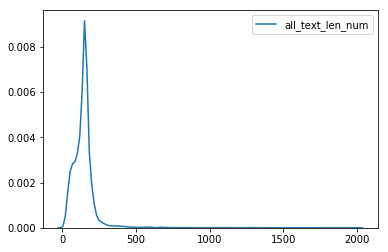

In [30]:
%matplotlib inline

import seaborn as sns
sns.kdeplot(data['all_text_len_num'])

In [31]:
import jieba

def cut_words(x):
    
    return ' '.join(jieba.cut(x))

cut_words("这是一个测试")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.739 seconds.
Prefix dict has been built succesfully.


'这是 一个 测试'

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = [100,20,50]
text_features = []

text_feas = ['text','userDescription','All_text']

X_text = data[text_feas]


for a,i in enumerate(text_feas):
    # Initialize decomposition methods:
    X_text[i] = X_text[i].astype(str)
    X_text[i] = X_text[i].apply(lambda x:cut_words(x))
    
    
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(n_components=n_components[a], random_state=1337)
    nmf_ = NMF(n_components=n_components[a], random_state=1337)
    lda_ = LatentDirichletAllocation(n_topics=10,random_state=1337,n_jobs=6)
    #pca_ = PCA(n_components=n_components[a], random_state=1993, whiten=True)
    #print(X_text.loc[:, i].values[:10])

    tfidf_col = TfidfVectorizer(min_df=3, ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1).fit_transform(X_text.loc[:, i].values)

    print("SVD")
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    print("NMF")
    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    print("LDA")
    lda_col = lda_.fit_transform(tfidf_col)
    lda_col = pd.DataFrame(lda_col)
    lda_col = lda_col.add_prefix('LDA_{}_'.format(i))

    # print("PCA")
    # pca_col = pca_.fit_transform(tfidf_col)
    # pca_col = pd.DataFrame(pca_col)
    # pca_col = pca_col.add_prefix('PCA_{}_'.format(i))

    text_features.append(svd_col)
    text_features.append(nmf_col)
    text_features.append(lda_col)
    
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


generating features from: text
SVD
NMF
LDA


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


generating features from: userDescription
SVD
NMF
LDA


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


generating features from: All_text
SVD
NMF
LDA


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [33]:
data = pd.concat([data,text_features],axis=1)

In [34]:
drop_feas = ['id','label','piclist', 'piclist_path','is_fake_pic']
features = [i for i in data.columns if i not in drop_feas ]
print(features)

['category', 'text', 'userDescription', 'userFansCount', 'userFollowCount', 'userGender', 'userLocation', 'userWeiboCount', 'contanis_tab', 'pic_0', 'pic_1', 'pic_2', 'pic_3', 'pic_4', 'pic_5', 'pic_6', 'pic_7', 'pic_8', 'pic_9', 'pic_10', 'pic_11', 'pic_12', 'pic_13', 'pic_14', 'pic_15', 'pic_16', 'pic_17', 'pic_18', 'pic_19', 'pic_20', 'pic_21', 'pic_22', 'pic_23', 'pic_24', 'pic_25', 'pic_26', 'pic_27', 'pic_28', 'pic_29', 'pic_30', 'pic_31', 'pic_32', 'pic_33', 'pic_34', 'pic_35', 'pic_36', 'pic_37', 'pic_38', 'pic_39', 'pic_40', 'pic_41', 'pic_42', 'pic_43', 'pic_44', 'pic_45', 'pic_46', 'pic_47', 'pic_48', 'pic_49', 'pic_50', 'pic_51', 'pic_52', 'pic_53', 'pic_54', 'pic_55', 'pic_56', 'pic_57', 'pic_58', 'pic_59', 'pic_60', 'pic_61', 'pic_62', 'pic_63', 'pic_64', 'pic_65', 'pic_66', 'pic_67', 'pic_68', 'pic_69', 'pic_70', 'pic_71', 'pic_72', 'pic_73', 'pic_74', 'pic_75', 'pic_76', 'pic_77', 'pic_78', 'pic_79', 'pic_80', 'pic_81', 'pic_82', 'pic_83', 'pic_84', 'pic_85', 'pic_86', 

In [35]:
object_feas = [i for i in features if str(data[i].dtype)=='object']
print(object_feas)

['category', 'text', 'userDescription', 'userGender', 'userLocation', 'All_text']


In [36]:
for fea in object_feas:
    data[fea] = pd.factorize(data[fea])[0]
    data[fea+"_freq"] = data[fea].map(data[fea].value_counts(dropna=False))

In [57]:
import tqdm

train = data[data.label.notna()]
test = data[data.label.isna()]

def get_data_ctr_fea(tj_data, self_data, features, target):
    items = features

    tj_drop_columns = [i for i in tj_data if "_ctr" in i]
    if len(tj_drop_columns) > 0:
        tj_data = tj_data.drop(columns=tj_drop_columns)

    self_drop_columns = [i for i in self_data if "_ctr" in i]
    if len(self_drop_columns) > 0:
        print(self_drop_columns)
        self_data.drop(columns=self_drop_columns, inplace=True)

    for item in tqdm.tqdm(items):
        if type(item) == list:
            pr_name = "_".join(item)
            merge_columns = item + [pr_name + '_ctr']
        else:
            pr_name = item
            merge_columns = [item, pr_name + '_ctr']
        temp = tj_data.groupby(item, as_index=False)[target].agg(
            {pr_name + '_click': 'sum', pr_name + '_count': 'count'})
        temp[pr_name + '_ctr'] = 1000000 * (temp[pr_name + '_click'] + 0.01) / (temp[pr_name + '_count'] + 0.01)

        self_data = pd.merge(self_data, temp[merge_columns], on=item, how='left')

    #     items = items[:5]
    #     for i in range(len(items)):
    #         for j in range(i+1, len(items)):
    #             item_g = [items[i], items[j]]
    #             merge_columns=item_g+['_'.join(item_g)+'_ctr']
    #             temp = tj_data.groupby(item_g, as_index=False)[target].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'count':'count'})
    #             temp['_'.join(item_g)+'_ctr'] =100* (temp['_'.join(item_g)+'_click']+0.01)/(temp['_'.join(item_g)+'count']+0.01)
    #     、
    #     self_data = pd.merge(self_data, temp[merge_columns], on=item_g, how='left')

    return self_data


ctr_fea = object_feas+['contanis_tab']

test = get_data_ctr_fea(train, test, ctr_fea, 'label')

skf = StratifiedKFold(n_splits=5,random_state=4590,shuffle=True)


def get_train_ctr_fea(train_data, skf, features, target):
    train_data['index'] = [i for i in range(len(train_data))]
    for k, (train_in, test_in) in enumerate(skf.split(train_data,train_data[target])):
        train_df = train_data.iloc[train_in]
        val_df = train_data.iloc[test_in]
        val_df = get_data_ctr_fea(train_df, val_df, features, target)
        if k == 0:
            new_train_df = val_df
        else:
            new_train_df = pd.concat([new_train_df, val_df])

    train_data = new_train_df
    train_data.sort_values(by='index', inplace=True)
    del train_data['index']
    train_data.reset_index(drop=True, inplace=True)

    return train_data


train = get_train_ctr_fea(train, skf, ctr_fea, 'label')

data = pd.concat([train, test])

del train, test
gc.collect()


['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
100%|██████████| 7/7 [00:00<00:00, 32.45it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
  0%|          | 0/7 [00

['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


100%|██████████| 7/7 [00:00<00:00, 25.39it/s]


['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


100%|██████████| 7/7 [00:00<00:00, 22.70it/s]


['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


100%|██████████| 7/7 [00:00<00:00, 24.12it/s]


['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


100%|██████████| 7/7 [00:00<00:00, 24.35it/s]


['category_ctr', 'text_ctr', 'userDescription_ctr', 'userGender_ctr', 'userLocation_ctr', 'All_text_ctr']


100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


259

In [58]:
train = data[data.label.notna()]
test = data[data.label.isna()]

In [59]:
print(train['label'].value_counts())

1.0    19285
0.0    19186
Name: label, dtype: int64


In [60]:
print(len(test))

3999


In [61]:
features = [i for i in data.columns if i not in drop_feas ]


In [62]:
print(features)

['category', 'text', 'userDescription', 'userFansCount', 'userFollowCount', 'userGender', 'userLocation', 'userWeiboCount', 'contanis_tab', 'pic_0', 'pic_1', 'pic_2', 'pic_3', 'pic_4', 'pic_5', 'pic_6', 'pic_7', 'pic_8', 'pic_9', 'pic_10', 'pic_11', 'pic_12', 'pic_13', 'pic_14', 'pic_15', 'pic_16', 'pic_17', 'pic_18', 'pic_19', 'pic_20', 'pic_21', 'pic_22', 'pic_23', 'pic_24', 'pic_25', 'pic_26', 'pic_27', 'pic_28', 'pic_29', 'pic_30', 'pic_31', 'pic_32', 'pic_33', 'pic_34', 'pic_35', 'pic_36', 'pic_37', 'pic_38', 'pic_39', 'pic_40', 'pic_41', 'pic_42', 'pic_43', 'pic_44', 'pic_45', 'pic_46', 'pic_47', 'pic_48', 'pic_49', 'pic_50', 'pic_51', 'pic_52', 'pic_53', 'pic_54', 'pic_55', 'pic_56', 'pic_57', 'pic_58', 'pic_59', 'pic_60', 'pic_61', 'pic_62', 'pic_63', 'pic_64', 'pic_65', 'pic_66', 'pic_67', 'pic_68', 'pic_69', 'pic_70', 'pic_71', 'pic_72', 'pic_73', 'pic_74', 'pic_75', 'pic_76', 'pic_77', 'pic_78', 'pic_79', 'pic_80', 'pic_81', 'pic_82', 'pic_83', 'pic_84', 'pic_85', 'pic_86', 

In [65]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import  StratifiedKFold

params =   {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'n_jobs':100,
                    'learning_rate':0.02,
                    'num_leaves': 31,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.4,
                    'subsample_freq':1,
                    'subsample':0.7,
                   # 'n_estimators':10000,
                    'max_bin':255,
                    'verbose':0,
#                    "min_data_in_leaf":80,
                   "lambda_l1" : 0.1,
                   "lambda_l2" : 0.1,
                    'seed': 1993,
                   # 'early_stopping_rounds':200, 
                } 

from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True



# Additional parameters:
early_stop = 200
verbose_eval = 5
num_rounds = 10000
n_splits = 5
NFOLD=5

lgb_oof_train = np.zeros((train.shape[0],1))
lgb_oof_test = np.zeros((test.shape[0],1))
skf = StratifiedKFold(n_splits=5,random_state=4590,shuffle=True)


categorical_columns = object_feas

# for idx, (train_index, valid_index) in enumerate(kf.split(train_df, y, rescuerID)):
    
feature_importance = pd.DataFrame()
score_csv = []
    
    
# for train_index, valid_index in  (skf.split(X_train[features],X_train['AdoptionSpeed'])):
for k,(train_index, valid_index) in  enumerate(skf.split(train[features],train['label'])):

    
    X_tr = train.iloc[train_index, :][features]
    X_val = train.iloc[valid_index, :][features]
    
    y_tr = train.iloc[train_index, :]['label']
    
    y_val = train.iloc[valid_index, :]['label']
    
    
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature=categorical_columns)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,feval=lgb_f1_score)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(test[features], num_iteration=model.best_iteration)
    
    lgb_oof_train[valid_index] = val_pred.reshape(-1,1)
    lgb_oof_test += test_pred.reshape(-1,1)/n_splits
    
    print("fold %d f1 is :%f"%(k,f1_score(y_val,(val_pred>0.5).astype(int))))
    score_csv.append(f1_score(y_val,(val_pred>0.5).astype(int)))
    
        
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = features
    fold_importance["importance"] = model.feature_importance()
    fold_importance["fold"] = k + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


training LGB:


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['All_text', 'category', 'text', 'userDescription', 'userGender', 'userLocation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[5]	training's binary_logloss: 0.617001	training's f1: 0.970262	valid_1's binary_logloss: 0.617845	valid_1's f1: 0.966046
[10]	training's binary_logloss: 0.551192	training's f1: 0.973669	valid_1's binary_logloss: 0.55283	valid_1's f1: 0.970347
[15]	training's binary_logloss: 0.49386	training's f1: 0.974587	valid_1's binary_logloss: 0.495988	valid_1's f1: 0.969681
[20]	training's binary_logloss: 0.447009	training's f1: 0.974766	valid_1's binary_logloss: 0.449578	valid_1's f1: 0.971708
[25]	training's binary_logloss: 0.404224	training's f1: 0.975416	valid_1's binary_logloss: 0.407245	valid_1's f1: 0.971081
[30]	training's binary_logloss: 0.368017	training's f1: 0.975863	valid_1's binary_logloss: 0.371471	valid_1's f1: 0.971451
[35]	training's binary_logloss: 0.336136	training's f1: 0.976509	valid_1's binary_logloss: 0.339962	valid_1's f1: 0.972101
[40]	training's binary_logloss: 0.308685	training's f1: 0.9772	valid_1's binary

[335]	training's binary_logloss: 0.0227401	training's f1: 0.9963	valid_1's binary_logloss: 0.0398249	valid_1's f1: 0.985908
[340]	training's binary_logloss: 0.0222316	training's f1: 0.996397	valid_1's binary_logloss: 0.0394609	valid_1's f1: 0.98604
[345]	training's binary_logloss: 0.0217203	training's f1: 0.996625	valid_1's binary_logloss: 0.0391879	valid_1's f1: 0.98604
[350]	training's binary_logloss: 0.0212167	training's f1: 0.996983	valid_1's binary_logloss: 0.0388928	valid_1's f1: 0.98578
[355]	training's binary_logloss: 0.0207444	training's f1: 0.997113	valid_1's binary_logloss: 0.0386238	valid_1's f1: 0.985783
[360]	training's binary_logloss: 0.0202586	training's f1: 0.99721	valid_1's binary_logloss: 0.0382434	valid_1's f1: 0.986305
[365]	training's binary_logloss: 0.0197805	training's f1: 0.997242	valid_1's binary_logloss: 0.037886	valid_1's f1: 0.986437
[370]	training's binary_logloss: 0.0193272	training's f1: 0.997405	valid_1's binary_logloss: 0.0375527	valid_1's f1: 0.986437

[670]	training's binary_logloss: 0.00606136	training's f1: 1	valid_1's binary_logloss: 0.0309677	valid_1's f1: 0.987757
[675]	training's binary_logloss: 0.00596156	training's f1: 1	valid_1's binary_logloss: 0.0309222	valid_1's f1: 0.987493
[680]	training's binary_logloss: 0.00586118	training's f1: 1	valid_1's binary_logloss: 0.0308766	valid_1's f1: 0.987493
[685]	training's binary_logloss: 0.00575968	training's f1: 1	valid_1's binary_logloss: 0.0307855	valid_1's f1: 0.987625
[690]	training's binary_logloss: 0.0056663	training's f1: 1	valid_1's binary_logloss: 0.030785	valid_1's f1: 0.987629
[695]	training's binary_logloss: 0.00556716	training's f1: 1	valid_1's binary_logloss: 0.0307226	valid_1's f1: 0.987629
[700]	training's binary_logloss: 0.00547923	training's f1: 1	valid_1's binary_logloss: 0.0307098	valid_1's f1: 0.987889
[705]	training's binary_logloss: 0.00538975	training's f1: 1	valid_1's binary_logloss: 0.0306726	valid_1's f1: 0.987632
[710]	training's binary_logloss: 0.0052975

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['All_text', 'category', 'text', 'userDescription', 'userGender', 'userLocation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[5]	training's binary_logloss: 0.617407	training's f1: 0.968267	valid_1's binary_logloss: 0.617935	valid_1's f1: 0.96736
[10]	training's binary_logloss: 0.551916	training's f1: 0.972902	valid_1's binary_logloss: 0.552894	valid_1's f1: 0.972511
[15]	training's binary_logloss: 0.494417	training's f1: 0.9742	valid_1's binary_logloss: 0.495966	valid_1's f1: 0.972952
[20]	training's binary_logloss: 0.447259	training's f1: 0.974995	valid_1's binary_logloss: 0.448985	valid_1's f1: 0.973874
[25]	training's binary_logloss: 0.40427	training's f1: 0.975506	valid_1's binary_logloss: 0.406343	valid_1's f1: 0.974009
[30]	training's binary_logloss: 0.368133	training's f1: 0.976022	valid_1's binary_logloss: 0.370543	valid_1's f1: 0.97481
[35]	training's binary_logloss: 0.336288	training's f1: 0.976568	valid_1's binary_logloss: 0.339079	valid_1's f1: 0.974931
[40]	training's binary_logloss: 0.308893	training's f1: 0.976992	valid_1's binary_

[335]	training's binary_logloss: 0.0224871	training's f1: 0.996527	valid_1's binary_logloss: 0.0411674	valid_1's f1: 0.984904
[340]	training's binary_logloss: 0.0219806	training's f1: 0.996625	valid_1's binary_logloss: 0.0408954	valid_1's f1: 0.984904
[345]	training's binary_logloss: 0.0214982	training's f1: 0.996755	valid_1's binary_logloss: 0.0406658	valid_1's f1: 0.985032
[350]	training's binary_logloss: 0.021	training's f1: 0.99695	valid_1's binary_logloss: 0.0403217	valid_1's f1: 0.984904
[355]	training's binary_logloss: 0.0205338	training's f1: 0.997113	valid_1's binary_logloss: 0.0399954	valid_1's f1: 0.984772
[360]	training's binary_logloss: 0.0200594	training's f1: 0.99734	valid_1's binary_logloss: 0.0396747	valid_1's f1: 0.984904
[365]	training's binary_logloss: 0.0196171	training's f1: 0.997372	valid_1's binary_logloss: 0.0393947	valid_1's f1: 0.985036
[370]	training's binary_logloss: 0.019168	training's f1: 0.997535	valid_1's binary_logloss: 0.0391177	valid_1's f1: 0.984904

[665]	training's binary_logloss: 0.00607456	training's f1: 1	valid_1's binary_logloss: 0.0325232	valid_1's f1: 0.987388
[670]	training's binary_logloss: 0.00597504	training's f1: 1	valid_1's binary_logloss: 0.0324888	valid_1's f1: 0.987131
[675]	training's binary_logloss: 0.00587155	training's f1: 1	valid_1's binary_logloss: 0.0324376	valid_1's f1: 0.987003
[680]	training's binary_logloss: 0.00577474	training's f1: 1	valid_1's binary_logloss: 0.032356	valid_1's f1: 0.987131
[685]	training's binary_logloss: 0.0056769	training's f1: 1	valid_1's binary_logloss: 0.0323167	valid_1's f1: 0.987003
[690]	training's binary_logloss: 0.00557612	training's f1: 1	valid_1's binary_logloss: 0.032266	valid_1's f1: 0.987003
[695]	training's binary_logloss: 0.00548427	training's f1: 1	valid_1's binary_logloss: 0.0322201	valid_1's f1: 0.987003
[700]	training's binary_logloss: 0.00539198	training's f1: 1	valid_1's binary_logloss: 0.0321768	valid_1's f1: 0.987263
[705]	training's binary_logloss: 0.00530175

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['All_text', 'category', 'text', 'userDescription', 'userGender', 'userLocation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[5]	training's binary_logloss: 0.617362	training's f1: 0.969914	valid_1's binary_logloss: 0.618497	valid_1's f1: 0.963012
[10]	training's binary_logloss: 0.551574	training's f1: 0.975005	valid_1's binary_logloss: 0.55376	valid_1's f1: 0.969951
[15]	training's binary_logloss: 0.494015	training's f1: 0.975032	valid_1's binary_logloss: 0.496984	valid_1's f1: 0.969164
[20]	training's binary_logloss: 0.446772	training's f1: 0.976094	valid_1's binary_logloss: 0.450361	valid_1's f1: 0.969673
[25]	training's binary_logloss: 0.403873	training's f1: 0.976842	valid_1's binary_logloss: 0.408135	valid_1's f1: 0.970538
[30]	training's binary_logloss: 0.367693	training's f1: 0.977115	valid_1's binary_logloss: 0.372698	valid_1's f1: 0.970157
[35]	training's binary_logloss: 0.335866	training's f1: 0.977543	valid_1's binary_logloss: 0.341445	valid_1's f1: 0.970673
[40]	training's binary_logloss: 0.308431	training's f1: 0.977696	valid_1's bin

[335]	training's binary_logloss: 0.0219192	training's f1: 0.996919	valid_1's binary_logloss: 0.0451687	valid_1's f1: 0.983645
[340]	training's binary_logloss: 0.0214108	training's f1: 0.997146	valid_1's binary_logloss: 0.0448268	valid_1's f1: 0.983777
[345]	training's binary_logloss: 0.0209126	training's f1: 0.997308	valid_1's binary_logloss: 0.0444741	valid_1's f1: 0.983777
[350]	training's binary_logloss: 0.0204119	training's f1: 0.997405	valid_1's binary_logloss: 0.0441969	valid_1's f1: 0.983909
[355]	training's binary_logloss: 0.0199422	training's f1: 0.997438	valid_1's binary_logloss: 0.0439095	valid_1's f1: 0.983781
[360]	training's binary_logloss: 0.0194456	training's f1: 0.997503	valid_1's binary_logloss: 0.0436173	valid_1's f1: 0.983777
[365]	training's binary_logloss: 0.0189973	training's f1: 0.9976	valid_1's binary_logloss: 0.0433778	valid_1's f1: 0.983517
[370]	training's binary_logloss: 0.0185407	training's f1: 0.997795	valid_1's binary_logloss: 0.0431163	valid_1's f1: 0.9

[665]	training's binary_logloss: 0.00581295	training's f1: 1	valid_1's binary_logloss: 0.0360496	valid_1's f1: 0.985601
[670]	training's binary_logloss: 0.00571322	training's f1: 1	valid_1's binary_logloss: 0.035992	valid_1's f1: 0.985861
[675]	training's binary_logloss: 0.00561306	training's f1: 1	valid_1's binary_logloss: 0.0359303	valid_1's f1: 0.985733
[680]	training's binary_logloss: 0.00551481	training's f1: 1	valid_1's binary_logloss: 0.0358967	valid_1's f1: 0.985605
[685]	training's binary_logloss: 0.00541668	training's f1: 1	valid_1's binary_logloss: 0.0358205	valid_1's f1: 0.985605
[690]	training's binary_logloss: 0.00532373	training's f1: 1	valid_1's binary_logloss: 0.0357563	valid_1's f1: 0.985733
[695]	training's binary_logloss: 0.00523527	training's f1: 1	valid_1's binary_logloss: 0.0357499	valid_1's f1: 0.985733
[700]	training's binary_logloss: 0.00514229	training's f1: 1	valid_1's binary_logloss: 0.0357326	valid_1's f1: 0.985733
[705]	training's binary_logloss: 0.005055

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['All_text', 'category', 'text', 'userDescription', 'userGender', 'userLocation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[5]	training's binary_logloss: 0.617229	training's f1: 0.96944	valid_1's binary_logloss: 0.618192	valid_1's f1: 0.963061
[10]	training's binary_logloss: 0.551537	training's f1: 0.974524	valid_1's binary_logloss: 0.553394	valid_1's f1: 0.968816
[15]	training's binary_logloss: 0.493996	training's f1: 0.974691	valid_1's binary_logloss: 0.496547	valid_1's f1: 0.969873
[20]	training's binary_logloss: 0.446726	training's f1: 0.975384	valid_1's binary_logloss: 0.45012	valid_1's f1: 0.970417
[25]	training's binary_logloss: 0.403748	training's f1: 0.976001	valid_1's binary_logloss: 0.407921	valid_1's f1: 0.970169
[30]	training's binary_logloss: 0.367568	training's f1: 0.976476	valid_1's binary_logloss: 0.372248	valid_1's f1: 0.971519
[35]	training's binary_logloss: 0.335702	training's f1: 0.976633	valid_1's binary_logloss: 0.340879	valid_1's f1: 0.972303
[40]	training's binary_logloss: 0.308304	training's f1: 0.977019	valid_1's bina

[335]	training's binary_logloss: 0.0220834	training's f1: 0.996821	valid_1's binary_logloss: 0.0432312	valid_1's f1: 0.983602
[340]	training's binary_logloss: 0.0215941	training's f1: 0.996983	valid_1's binary_logloss: 0.0430196	valid_1's f1: 0.983863
[345]	training's binary_logloss: 0.0211169	training's f1: 0.996983	valid_1's binary_logloss: 0.0427035	valid_1's f1: 0.983735
[350]	training's binary_logloss: 0.0205961	training's f1: 0.99708	valid_1's binary_logloss: 0.0424517	valid_1's f1: 0.983871
[355]	training's binary_logloss: 0.0200962	training's f1: 0.997307	valid_1's binary_logloss: 0.0421269	valid_1's f1: 0.983743
[360]	training's binary_logloss: 0.0195972	training's f1: 0.99747	valid_1's binary_logloss: 0.0418241	valid_1's f1: 0.983875
[365]	training's binary_logloss: 0.0191569	training's f1: 0.997631	valid_1's binary_logloss: 0.041521	valid_1's f1: 0.983879
[370]	training's binary_logloss: 0.0186896	training's f1: 0.997664	valid_1's binary_logloss: 0.0412291	valid_1's f1: 0.98

[670]	training's binary_logloss: 0.00579205	training's f1: 1	valid_1's binary_logloss: 0.0348295	valid_1's f1: 0.984927
[675]	training's binary_logloss: 0.00568556	training's f1: 1	valid_1's binary_logloss: 0.0347761	valid_1's f1: 0.984927
[680]	training's binary_logloss: 0.00559269	training's f1: 1	valid_1's binary_logloss: 0.0347556	valid_1's f1: 0.985323
[685]	training's binary_logloss: 0.00549056	training's f1: 1	valid_1's binary_logloss: 0.0347567	valid_1's f1: 0.985059
[690]	training's binary_logloss: 0.00539642	training's f1: 1	valid_1's binary_logloss: 0.0346844	valid_1's f1: 0.985059
[695]	training's binary_logloss: 0.00530475	training's f1: 1	valid_1's binary_logloss: 0.0346643	valid_1's f1: 0.985451
[700]	training's binary_logloss: 0.00521858	training's f1: 1	valid_1's binary_logloss: 0.0346851	valid_1's f1: 0.985451
[705]	training's binary_logloss: 0.00513255	training's f1: 1	valid_1's binary_logloss: 0.0346544	valid_1's f1: 0.985319
[710]	training's binary_logloss: 0.00504

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['All_text', 'category', 'text', 'userDescription', 'userGender', 'userLocation']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[5]	training's binary_logloss: 0.617103	training's f1: 0.969655	valid_1's binary_logloss: 0.61705	valid_1's f1: 0.971775
[10]	training's binary_logloss: 0.551675	training's f1: 0.973393	valid_1's binary_logloss: 0.551638	valid_1's f1: 0.974865
[15]	training's binary_logloss: 0.494518	training's f1: 0.974448	valid_1's binary_logloss: 0.494257	valid_1's f1: 0.97477
[20]	training's binary_logloss: 0.447665	training's f1: 0.975252	valid_1's binary_logloss: 0.447544	valid_1's f1: 0.975815
[25]	training's binary_logloss: 0.404835	training's f1: 0.975767	valid_1's binary_logloss: 0.40463	valid_1's f1: 0.975578
[30]	training's binary_logloss: 0.36863	training's f1: 0.975691	valid_1's binary_logloss: 0.368668	valid_1's f1: 0.975315
[35]	training's binary_logloss: 0.336942	training's f1: 0.975775	valid_1's binary_logloss: 0.337116	valid_1's f1: 0.975315
[40]	training's binary_logloss: 0.309649	training's f1: 0.976305	valid_1's binary

[335]	training's binary_logloss: 0.022822	training's f1: 0.996593	valid_1's binary_logloss: 0.038961	valid_1's f1: 0.985711
[340]	training's binary_logloss: 0.0223001	training's f1: 0.996951	valid_1's binary_logloss: 0.038709	valid_1's f1: 0.985579
[345]	training's binary_logloss: 0.0218241	training's f1: 0.996983	valid_1's binary_logloss: 0.0383999	valid_1's f1: 0.985839
[350]	training's binary_logloss: 0.0213191	training's f1: 0.997145	valid_1's binary_logloss: 0.0381439	valid_1's f1: 0.985711
[355]	training's binary_logloss: 0.0208423	training's f1: 0.997211	valid_1's binary_logloss: 0.0379059	valid_1's f1: 0.985842
[360]	training's binary_logloss: 0.0203354	training's f1: 0.99734	valid_1's binary_logloss: 0.0376607	valid_1's f1: 0.985978
[365]	training's binary_logloss: 0.0198831	training's f1: 0.997438	valid_1's binary_logloss: 0.0373794	valid_1's f1: 0.985846
[370]	training's binary_logloss: 0.0194195	training's f1: 0.997503	valid_1's binary_logloss: 0.0371427	valid_1's f1: 0.985

[660]	training's binary_logloss: 0.00635	training's f1: 0.999968	valid_1's binary_logloss: 0.0311145	valid_1's f1: 0.98702
[665]	training's binary_logloss: 0.00624048	training's f1: 0.999968	valid_1's binary_logloss: 0.0310906	valid_1's f1: 0.986888
[670]	training's binary_logloss: 0.00613309	training's f1: 0.999968	valid_1's binary_logloss: 0.0310293	valid_1's f1: 0.986892
[675]	training's binary_logloss: 0.00602833	training's f1: 0.999968	valid_1's binary_logloss: 0.0309639	valid_1's f1: 0.986757
[680]	training's binary_logloss: 0.00592606	training's f1: 0.999968	valid_1's binary_logloss: 0.0309268	valid_1's f1: 0.986629
[685]	training's binary_logloss: 0.0058243	training's f1: 0.999968	valid_1's binary_logloss: 0.0308665	valid_1's f1: 0.98676
[690]	training's binary_logloss: 0.00572746	training's f1: 0.999968	valid_1's binary_logloss: 0.0307925	valid_1's f1: 0.986629
[695]	training's binary_logloss: 0.00563339	training's f1: 0.999968	valid_1's binary_logloss: 0.0307373	valid_1's f1:

In [66]:
mean_f1 = np.mean(score_csv)
print(mean_f1)

0.9860974239798288


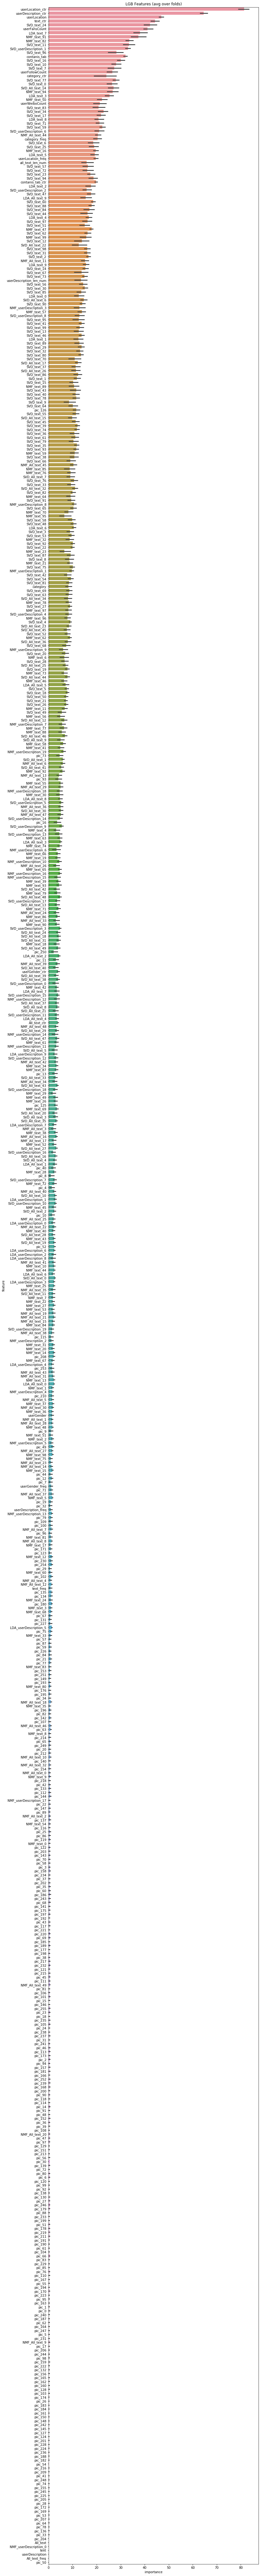

In [67]:
import matplotlib.pyplot as plt

feature_importance["importance"] /= 5
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:1000].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(12, 150));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [78]:
test['label'] = (lgb_oof_test>0.5).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
from sklearn.metrics import roc_curve, precision_recall_curve
def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result 

result = threshold_search(train.label.values,lgb_oof_train)
print(result)



{'threshold': 0.43767349165291597, 'f1': 0.9866742714922742}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [80]:
test.head(50)

,category,id,label,piclist,text,userDescription,userFansCount,userFollowCount,userGender,userLocation,...,userGender_freq,userLocation_freq,All_text_freq,category_ctr,text_ctr,userDescription_ctr,userGender_ctr,userLocation_ctr,All_text_ctr,contanis_tab_ctr
0,6,98a8deab7f69217558c6d39d7569de1f,1,b76f9ae026813de11a71ab6ee97d1948.png,20451,12426,6842.0,4899.0,0,702,...,25094,27,2,444162.746067,1000000.0,1000000.000000,403547.837596,1.000000e+06,1000000.000000,1000000.000000
1,3,b828f2306ff0a4572594d141b1f180a9,1,c05c3d7dc90ea9522f343aacfdf01e8b.jpg,33414,21401,34.0,257.0,1,29,...,16880,2655,1,482168.006347,NaN,NaN,651209.772871,6.144084e+05,NaN,256010.836044
2,6,ff4fda12a9ab29d00808f04e91ac7409,0,0a671ff09e9884a45a443b0a3895061e.jpg,33415,21402,10981.0,408.0,0,35,...,25094,338,1,444162.746067,NaN,NaN,403547.837596,5.254928e+05,NaN,256010.836044
3,1,40920b0a703c1d4dc10189551f159fd0,1,8f185307f4460d6adce83d2d2195a73e.jpg,33416,21403,923.0,682.0,0,489,...,25094,153,1,496548.706090,NaN,NaN,403547.837596,1.000000e+06,NaN,1000000.000000
4,0,1bba2f2251169f77711c323183190c5d,1,NaN,33417,21404,1051.0,349.0,0,520,...,25094,316,1,487864.998752,NaN,NaN,403547.837596,1.000000e+06,NaN,1000000.000000
5,1,680d89a506afbc9df33e0a055250cd87,1,NaN,33418,21405,220.0,374.0,1,745,...,16880,4,1,496548.706090,NaN,NaN,651209.772871,1.000000e+06,NaN,1000000.000000
6,4,3d5f136e09f69af229204459f7af3cb7,0,NaN,33419,21406,4809.0,357.0,1,13,...,16880,292,1,539241.154372,NaN,NaN,651209.772871,3.745178e+01,NaN,256010.836044
7,0,2d94a7409d31c6047d896ab7fa5ab1a4,0,NaN,33420,-1,NaN,NaN,-1,-1,...,496,598,8571,487864.998752,NaN,707194.157882,271926.473562,2.942403e+05,707194.157882,256010.836044
8,1,22498f6606b17dab939cbd1a79442618,1,NaN,19803,11979,39.0,384.0,0,773,...,25094,10,2,496548.706090,1000000.0,1000000.000000,403547.837596,1.000000e+06,1000000.000000,1000000.000000
9,0,d410905f5fa639be3f2cf2f36e5f30a6,0,NaN,33421,21407,29.0,145.0,0,9,...,25094,2872,1,487864.998752,NaN,NaN,403547.837596,3.216378e+05,NaN,256010.836044


In [81]:
test.label.value_counts()

0    2034
1    1965
Name: label, dtype: int64

In [82]:
train['pred'] = (lgb_oof_train>result['threshold']).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
train.pred.value_counts()

1    19286
0    19185
Name: pred, dtype: int64

In [84]:
test[['id','label']].to_csv("./sub/final_lgb_submit_f1_%f.csv"%result['f1'],index=False)

In [85]:
len(test)

3999

In [86]:
test[['id','label']]

,id,label
0,98a8deab7f69217558c6d39d7569de1f,1
1,b828f2306ff0a4572594d141b1f180a9,1
2,ff4fda12a9ab29d00808f04e91ac7409,0
3,40920b0a703c1d4dc10189551f159fd0,1
4,1bba2f2251169f77711c323183190c5d,1
5,680d89a506afbc9df33e0a055250cd87,1
6,3d5f136e09f69af229204459f7af3cb7,0
7,2d94a7409d31c6047d896ab7fa5ab1a4,0
8,22498f6606b17dab939cbd1a79442618,1
9,d410905f5fa639be3f2cf2f36e5f30a6,0


In [87]:
oof_train_df =  pd.DataFrame(lgb_oof_train)
oof_train_df.columns = ['class_0']
oof_train_df.to_csv("./oof_train/final_lgb_task3_oof_train_prob_%s.csv"%result['f1'],index=False)


oof_test_df =  pd.DataFrame(lgb_oof_test)
oof_test_df.columns = ['class_0']
oof_test_df.to_csv("./oof_test/final_lgb_task3_oof_test_prob_%s.csv"%result['f1'],index=False)

In [1]:
## image 

In [ ]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import h5py
import os
 
from keras.utils import np_utils, conv_utils
from keras.models import Model
from keras.layers import Flatten, Dense, Input 
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras import backend as K
 
def get_name_list(filepath):                #获取各个类别的名字
    pathDir =  os.listdir(filepath)
    out = []
    for allDir in pathDir:
        if os.path.isdir(os.path.join(filepath,allDir)):
            child = allDir.decode('gbk')    # .decode('gbk')是解决中文显示乱码问题
            out.append(child)
    return out
    
def eachFile(filepath):                 #将目录内的文件名放入列表中
    pathDir =  os.listdir(filepath)
    out = []
    for allDir in pathDir:
        child = allDir.decode('gbk')    # .decode('gbk')是解决中文显示乱码问题
        out.append(child)
    return out
 
def get_data(data_name,train_left=0.0,train_right=0.7,train_all=0.7,resize=True,data_format=None,t=''):   #从文件夹中获取图像数据
    file_name = os.path.join(pic_dir_out,data_name+t+'_'+str(train_left)+'_'+str(train_right)+'_'+str(Width)+"X"+str(Height)+".h5")   
    print file_name
    if os.path.exists(file_name):           #判断之前是否有存到文件中
        f = h5py.File(file_name,'r')
        if t=='train':
            X_train = f['X_train'][:]
            y_train = f['y_train'][:]
            f.close()
            return (X_train, y_train)
        elif t=='test':
            X_test = f['X_test'][:]
            y_test = f['y_test'][:]
            f.close()
            return (X_test, y_test)  
        else:
            return 
    data_format = conv_utils.normalize_data_format(data_format)
    pic_dir_set = eachFile(pic_dir_data)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    label = 0
    for pic_dir in pic_dir_set:
        print pic_dir_data+pic_dir
        if not os.path.isdir(os.path.join(pic_dir_data,pic_dir)):
            continue    
        pic_set = eachFile(os.path.join(pic_dir_data,pic_dir))
        pic_index = 0
        train_count = int(len(pic_set)*train_all)
        train_l = int(len(pic_set)*train_left)
        train_r = int(len(pic_set)*train_right)
        for pic_name in pic_set:
            if not os.path.isfile(os.path.join(pic_dir_data,pic_dir,pic_name)):
                continue        
            img = cv2.imread(os.path.join(pic_dir_data,pic_dir,pic_name))
            if img is None:
                continue
            if (resize):
                img = cv2.resize(img,(Width,Height))   
                img = img.reshape(-1,Width,Height,3)
            if (pic_index < train_count):
                if t=='train':
                    if (pic_index >= train_l and pic_index < train_r):
                        X_train.append(img)
                        y_train.append(label)  
            else:
                if t=='test':
                    X_test.append(img)
                    y_test.append(label)
            pic_index += 1
        if len(pic_set) <> 0:        
            label += 1
    
    f = h5py.File(file_name,'w') 
    if t=='train':
        X_train = np.concatenate(X_train,axis=0)     
        y_train = np.array(y_train)      
        f.create_dataset('X_train', data = X_train)
        f.create_dataset('y_train', data = y_train)
        f.close()
        return (X_train, y_train)
    elif t=='test':
        X_test = np.concatenate(X_test,axis=0) 
        y_test = np.array(y_test)
        f.create_dataset('X_test', data = X_test)
        f.create_dataset('y_test', data = y_test)
        f.close()
        return (X_test, y_test)   
    else:
        return
 
def main():
    global Width, Height, pic_dir_out, pic_dir_data
    Width = 224
    Height = 224
    num_classes = 102               #Caltech101为102  cifar10为10
    pic_dir_out = './data/tasks/train/'  
    pic_dir_data = './data/tasks/train/'
    sub_dir = '224_resnet50/'
    if not os.path.isdir(os.path.join(pic_dir_out,sub_dir)):
        os.mkdir(os.path.join(pic_dir_out,sub_dir))
    pic_dir_mine = os.path.join(pic_dir_out,sub_dir)
    (X_train, y_train) = get_data("Caltech101_color_data_",0.0,0.7,data_format='channels_last',t='train')
    y_train = np_utils.to_categorical(y_train, num_classes)
 
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(input_tensor=input_tensor,include_top=False,weights='imagenet')
    #base_model = ResNet50(input_tensor=input_tensor,include_top=False,weights=None)
    get_resnet50_output = K.function([base_model.layers[0].input, K.learning_phase()],
                              [base_model.layers[-1].output])
 
    file_name = os.path.join(pic_dir_mine,'resnet50_train_output'+'.h5')
    if os.path.exists(file_name):
        f = h5py.File(file_name,'r')
        resnet50_train_output = f['resnet50_train_output'][:]
        f.close()
    else:
        resnet50_train_output = []
        delta = 10
        for i in range(0,len(X_train),delta):
            print i
            one_resnet50_train_output = get_resnet50_output([X_train[i:i+delta], 0])[0]
            resnet50_train_output.append(one_resnet50_train_output)
        resnet50_train_output = np.concatenate(resnet50_train_output,axis=0) 
        f = h5py.File(file_name,'w')          
        f.create_dataset('resnet50_train_output', data = resnet50_train_output)
        f.close()
 
    input_tensor = Input(shape=(1, 1, 2048))
    x = Flatten()(input_tensor)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)   
    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy'])
    
    print('\nTraining ------------')    #从文件中提取参数，训练后存在新的文件中
    cm = 0                              #修改这个参数可以多次训练
    cm_str = '' if cm==0 else str(cm)
    cm2_str = '' if (cm+1)==0 else str(cm+1) 
    if cm >= 1:
        model.load_weights(os.path.join(pic_dir_mine,'cnn_model_Caltech101_resnet50_'+cm_str+'.h5'))
    model.fit(resnet50_train_output, y_train, epochs=10, batch_size=128,) 
    model.save_weights(os.path.join(pic_dir_mine,'cnn_model_Caltech101_resnet50_'+cm2_str+'.h5'))
    
    (X_test, y_test) = get_data("Caltech101_color_data_",0.0,0.7,data_format='channels_last',t='test')    
    y_test = np_utils.to_categorical(y_test, num_classes)
        
    file_name = os.path.join(pic_dir_mine,'resnet50_test_output'+'.h5')
    if os.path.exists(file_name):
        f = h5py.File(file_name,'r')
        resnet50_test_output = f['resnet50_test_output'][:]
        f.close()
    else:
        resnet50_test_output = []
        delta = 10
        for i in range(0,len(X_test),delta):
            print i
            one_resnet50_test_output = get_resnet50_output([X_test[i:i+delta], 0])[0]
            resnet50_test_output.append(one_resnet50_test_output)
        resnet50_test_output = np.concatenate(resnet50_test_output,axis=0)
        f = h5py.File(file_name,'w')          
        f.create_dataset('resnet50_test_output', data = resnet50_test_output)
        f.close()
    print('\nTesting ------------')     #对测试集进行评估
    class_name_list = get_name_list(pic_dir_data)    #获取top-N的每类的准确率
    pred = model.predict(resnet50_test_output, batch_size=32)
    f = h5py.File(os.path.join(pic_dir_mine,'pred_'+cm2_str+'.h5'),'w')          
    f.create_dataset('pred', data = pred)
    f.close()
    
    N = 1
    pred_list = []
    for row in pred:
        pred_list.append(row.argsort()[-N:][::-1])  #获取最大的N个值的下标
    pred_array = np.array(pred_list)
    test_arg = np.argmax(y_test,axis=1)
    class_count = [0 for _ in xrange(num_classes)]
    class_acc = [0 for _ in xrange(num_classes)]
    for i in xrange(len(test_arg)):
        class_count[test_arg[i]] += 1
        if test_arg[i] in pred_array[i]:
            class_acc[test_arg[i]] += 1
    print('top-'+str(N)+' all acc:',str(sum(class_acc))+'/'+str(len(test_arg)),sum(class_acc)/float(len(test_arg)))
    for i in xrange(num_classes):
        print (i, class_name_list[i], 'acc: '+str(class_acc[i])+'/'+str(class_count[i]))
    
    print('----------------------------------------------------')
    N = 5
    pred_list = []
    for row in pred:
        pred_list.append(row.argsort()[-N:][::-1])  #获取最大的N个值的下标
    pred_array = np.array(pred_list)
    test_arg = np.argmax(y_test,axis=1)
    class_count = [0 for _ in xrange(num_classes)]
    class_acc = [0 for _ in xrange(num_classes)]
    for i in xrange(len(test_arg)):
        class_count[test_arg[i]] += 1
        if test_arg[i] in pred_array[i]:
            class_acc[test_arg[i]] += 1
    print('top-'+str(N)+' all acc:',str(sum(class_acc))+'/'+str(len(test_arg)),sum(class_acc)/float(len(test_arg)))
    for i in xrange(num_classes):
        print (i, class_name_list[i], 'acc: '+str(class_acc[i])+'/'+str(class_count[i]))
      
if __name__ == '__main__':
    main()



In [6]:
pip install opencv-python

     |████████████████████████████████| 28.7MB 1.3MB/s eta 0:00:01     |███████████████                 | 13.4MB 1.5MB/s eta 0:00:10
Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch.utils.data
from pathlib import Path
import numpy as np

from torchvision import transforms
import cv2
filename="./data/task3/train/rumor_pic/"
data_root=Path(image_paths)
#img = cv2.imread(filename)

In [16]:
second_image_paths = list(data_root.glob('*/*'))
second_image_paths=[str(path) for path in second_image_paths]

In [17]:
second_image_paths

[]